# Localized analysis: band-pass filtering, Hilbert transform

We investigate how band-pass filtering and hilbert transform can be combined in order to extract a tidal signal from the sum of a tidal signal and a low-frequency signal.
See the [main notebook](main.ipynb) for descriptions of the signal and of the filtering and hilbert transforms.

The tidal signal is non-stationary for now, i.e. there is no stationary contribution.

In [1]:
import xarray as xr
import numpy as np

from scipy import signal
import scipy.ndimage as im

import matplotlib.pyplot as plt

from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts
import sstats.sigp as sigp
from sstats import get_cmap_colors
#import mitequinox.sigp as sp

rad = 2*np.pi

print_figs = True

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#
#cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#
#w = cluster.scale(jobs=2)
#
client = Client(cluster)

distributed.diskutils - INFO - Found stale lock file and directory '/home1/datahome/zcaspar/equinox_phd/synthetic_stats/dask-worker-space/worker-b73gmwxv', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home1/datahome/zcaspar/equinox_phd/synthetic_stats/dask-worker-space/worker-s_7s0z_o', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home1/datahome/zcaspar/equinox_phd/synthetic_stats/dask-worker-space/worker-tg_0nskd', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home1/datahome/zcaspar/equinox_phd/synthetic_stats/dask-worker-space/worker-nlyv7nvl', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home1/datahome/zcaspar/equinox_phd/synthetic_stats/dask-worker-space/worker-mt2iaoag', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home1/datahome/zcaspar/equinox_phd/synthetic_stats/dask-worker-space/worker-rep_whg2', purging
distributed.disk

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52489,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:43287,Total threads: 7
Dashboard: http://127.0.0.1:42662/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:49207,


## filter design: firwin vs firwin2

Should probably include alternatives (equivalent to harmonic analysis over a fixed window)

[Link to scipy documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#filter-design)

In [4]:
def generate_filter(band, T=10, dt=1/24, lat=None, bandwidth=None, normalized_bandwidth=None):
    """Wrapper around scipy.signal.firwing
    
    Parameters
    ----------
    band: str, float
        Frequency band (e.g. "semidiurnal", ...) or filter central frequency
    T: float
        Filter length in days
    dt: float
        Filter/time series time step
    lat: float
        Latitude (for inertial band)
    bandwidth: float
        Filter bandwidth in cpd
    dt: float
        hours
    """
    numtaps = int(T*24)    
    pass_zero = False
    #
    if band == "subdiurnal":
        pass_zero = True
        cutoff = [1.0 / 2.0]    
    elif band == "semidiurnal":
        omega = 1.9322 #  M2 24/12.4206012 = 1.9322
    elif band == "diurnal":
        omega = 1. # K1 24/23.93447213 = 1.0027
    elif band == "inertial":
        try:
            omega = coriolis(lat) * 3600 / 2.0 / np.pi
        except:
            print("latitude needs to be provided to generate_filter")
    elif isinstance(band, float):
        omega = band
    #
    if bandwidth is not None:
        cutoff = [omega - bandwidth, omega + bandwidth]
    elif normalized_bandwidth is not None:
        cutoff = [omega * (1 - normalized_bandwidth), 
                  omega * (1.0 + normalized_bandwidth),
                 ]
    elif band != "subdiurnal":
        print("bandwidth or normalized_bandwidth needs to be provided")
    #
    h = signal.firwin(
        numtaps, cutoff=cutoff, pass_zero=pass_zero, fs=1/dt, scale=True
    )
    return h

def filter_response(h, dt=1/24):
    """Returns the frequency response"""
    w, hh = signal.freqz(h, worN=8000, fs=1/dt)
    return hh, w

def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}



In [5]:
dt = 1/24 # time step in days

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth

In [6]:
h = generate_filter(omega, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)

In [7]:
h_hat, w = filter_response(h, dt)

No handles with labels found to put in legend.


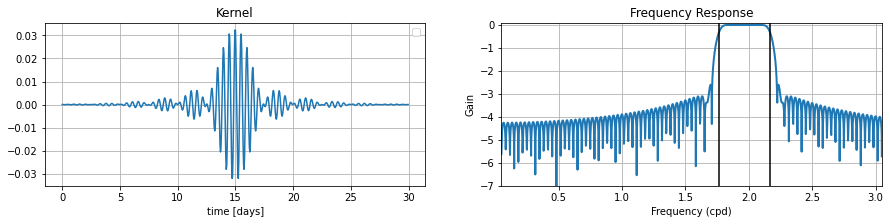

In [8]:
t = np.arange(0,30,dt)
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]

ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-dband, color='k')
ax.axvline(omega+dband, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

---

## Hilbert transform

### apply band-passed filter and hilbert transform

### Testing parameters

In [9]:
# generate synthetic data
#T,T_low = [14,29,80],10

def rename_attrs(da, **kwargs):
    """ rename attributes
    """
    for k_new, k_old in kwargs.items():
        da = da.assign_attrs(**{k_new: da.attrs.pop(k_old)})
    return da

def tseries(kind, u_high,u_low,T,T_low, params={}, **kwargs):
    _kwargs = dict(time=(1000, 1/24), 
                   seed=0,
                  )
    _kwargs.update(**kwargs)
    #               T=10.,
    if kind=="high_M2":
        p = dict(U=[0.01, 0.05,.1, 1.], T=T, sigma=omega_M2*rad)
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = (#rename_attrs(da, T_high="T")
              da.rename(U='U_high')
             )
    elif kind=="high_S2":
        p = dict(U=[0.01, 0.05,.1, 1.], T=T, sigma=omega_S2*rad)
        p.update(**params)
        da = (u_high
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = (#rename_attrs(da, T_high="T")
              da.rename(U='U_high')
             )
    else:
        p = dict(T=T_low)
        p.update(**params)
        da = (u_low
              .generate_tseries(params=p, **_kwargs)
              .persist()
             )
        da = rename_attrs(da, U_low="U") #T_low="T"
    return da

In [47]:
u_high.generate_tseries?

Signature: u_high.generate_tseries(params={}, **kwargs)
Docstring:
Generate synthetic data
calls tseries methods
File:      ~/synthetic_stats/sstats/hfreq.py
Type:      method


In [51]:
# actually generate time series
T,T_low = [5,10,15,30,80],[5,15,30]
u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()
da_high_M2 = tseries("high_M2",u_high,u_low,T,T_low).persist()
da_high_M2 = da_high_M2.rename('high_M2')
da_high_S2 = tseries("high_S2",u_high,u_low,T,T_low).persist()
da_high_S2 = da_high_S2.rename('high_S2')
da_low = tseries("low",u_high,u_low,T,T_low).persist()

In [52]:
da_high_M2.attrs = {'sigma_M2':da_high_M2.attrs['sigma']}
da_high_S2.attrs = {'sigma_S2':da_high_S2.attrs['sigma']}

ds = xr.merge([da_high_M2,da_high_S2, da_low.rename({'T':'T_low'})]) #, combine_attrs="no_conflicts"
#ds = ds.assign_coords({'T':T})
ds

<xarray.Dataset>
Dimensions:  (T: 5, U_high: 4, time: 24000, T_low: 3)
Coordinates:
  * T        (T) int64 5 10 15 30 80
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * T_low    (T_low) int64 5 15 30
Data variables:
    high_M2  (T, U_high, time) float64 dask.array<chunksize=(5, 4, 24000), meta=np.ndarray>
    high_S2  (T, U_high, time) float64 dask.array<chunksize=(5, 4, 24000), meta=np.ndarray>
    low      (T_low, time) float64 dask.array<chunksize=(3, 24000), meta=np.ndarray>
Attributes:
    sigma_M2:  12.140833182614747

In [53]:
ds['high'] = ds.high_M2+ds.high_S2
ds['total'] = ds.high_M2+ds.high_S2+ds.low

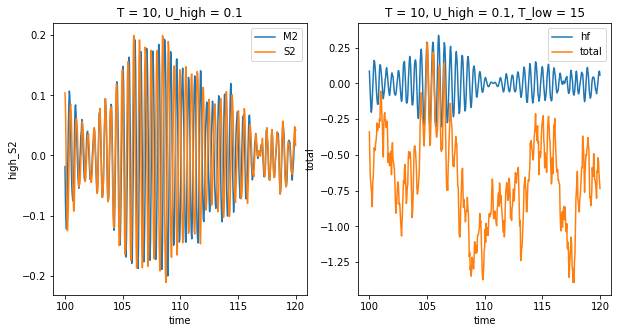

In [54]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ds.high_M2.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[0],label='M2')
ds.high_S2.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[0],label='S2')
ax[0].legend()
ds.high.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[1],label='hf')
ds.total.isel(T_low=1,T=1).sel(U_high=0.1).sel(time=slice(100,120)).plot(ax=ax[1],label='total')
ax[1].legend()

#### Filter and demodulation : 
Band pass filter applied to signal : 
1) monochromatic signal, M2 frequency

2) monochromatic signal, S2 frequency 

3) superpostion of S2 and M2 ; central frequency is the mean frequency

4) total signal (M2+S2+lf) ; central frequency is the mean frequency

Notes on paramters : 

1) halfbandwidth, $d\omega$, should be defined such as : $1/d\omega\geq T_w$; where $T_w$ is the kernel length

2) $d\omega\geq \tilde T$ ; where $\tilde T$ is the hf decorrelation timescale.

In [55]:
Tw = [15,30,60]
dband = [0.1,0.2,0.3]
_ds,h = {},{}
for om,kind in zip([omega_M2,omega_S2,omega,omega],['high_M2','high_S2','high','total']):
    _ds[kind] = xr.combine_nested([[sigp.bpass_demodulate(ds[[kind]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':dband})
    h[kind] = [[sigp.bpass_demodulate(ds[[kind]], om, band, tw)[1] for tw in Tw] for band in dband]


In [56]:
def autocorrelations(ds, V,combine=False):
#    V = ["high", "low"]
    if combine:
        ds["sum"] = ds["high"]  + ds["low"]
        ds["sum_demodulated"] = ds["high_demodulated"]  + ds["low_demodulated"]
        V = V + ["sum"]
    R = []
    for v in V:
        R.append((sigp
                  .correlate(ds[v+"_demodulated"].real, ds[v+"_demodulated"].real)
                  .rename(v)
                  .to_dataset()
                  .rename({'lags': 'tau'})
                 )
                )
    return xr.merge(R)
R = {}
for kind in ['high_M2','high_S2','high','total']:
    R[kind] = autocorrelations(_ds[kind],[kind])

In [57]:
ds_R = xr.merge([R[kind] for kind in ['high_M2','high_S2','high','total']])

In [58]:
ds_R = ds_R.compute()

#### Monochromatic signal ,M2

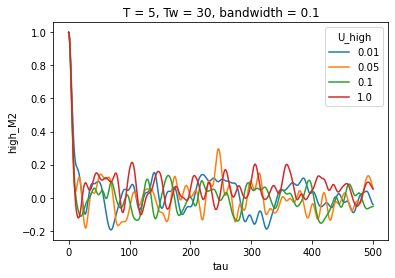

<Figure size 432x288 with 0 Axes>

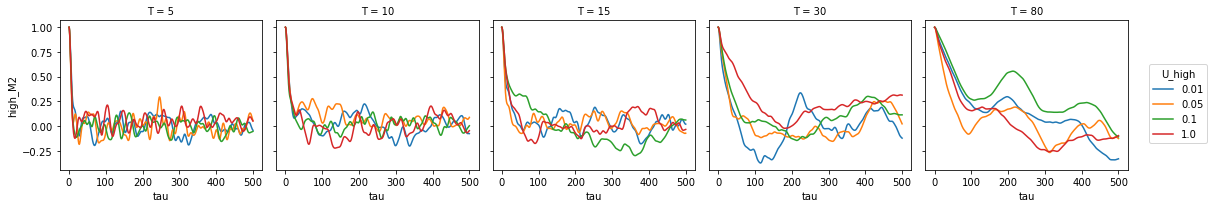

<Figure size 432x288 with 0 Axes>

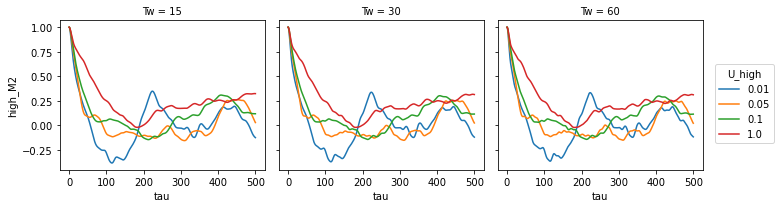

<Figure size 432x288 with 0 Axes>

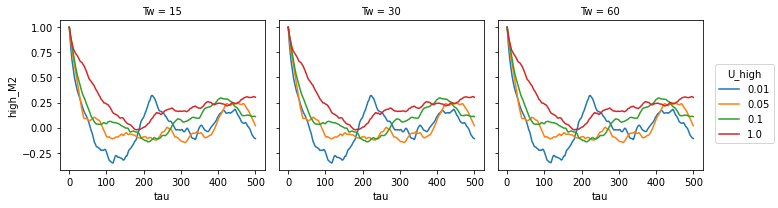

<Figure size 432x288 with 0 Axes>

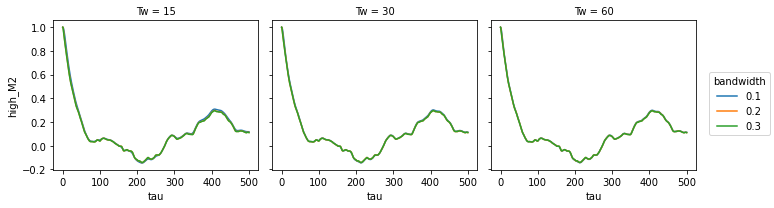

In [59]:
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.1,T=5,Tw=30).plot(hue='U_high')
plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.1,Tw=30).plot(hue='U_high',col='T')

plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.1,T=30).plot(hue='U_high',col='Tw')

plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(bandwidth=0.3,T=30).plot(hue='U_high',col='Tw')

plt.figure()
(ds_R.high_M2/ds_R.high_M2.isel(tau=0)).sel(T=30,U_high=0.1).plot(hue='bandwidth',col='Tw')

Notes : 

For large enough bandwidth compared to the decorrelation timescale, kernel length and bandwidth do not have impact on the results.

The form of autocovariance changes depending on the amplitude (mean over several samples should correct this).

NB : Short decorrealtion timescale compared to the band width ($\tilde T\leq T_\omega$) introduces oscillations in the autocovariance (expected)

#### High frequency signal (M2+S2)

<Figure size 432x288 with 0 Axes>

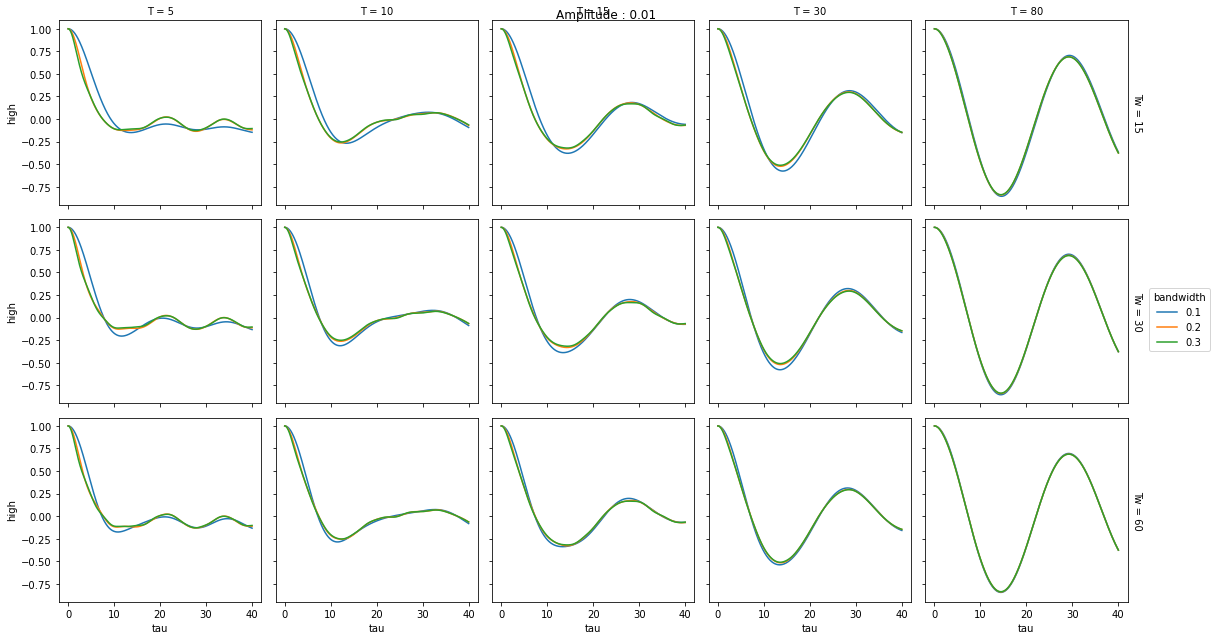

<Figure size 432x288 with 0 Axes>

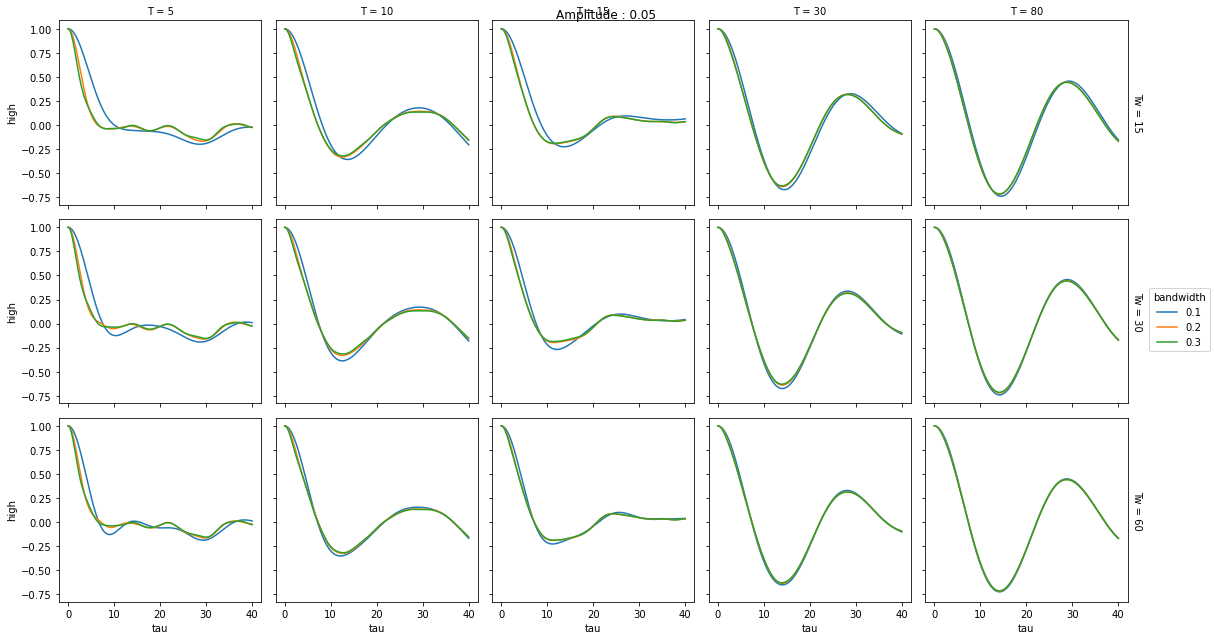

<Figure size 432x288 with 0 Axes>

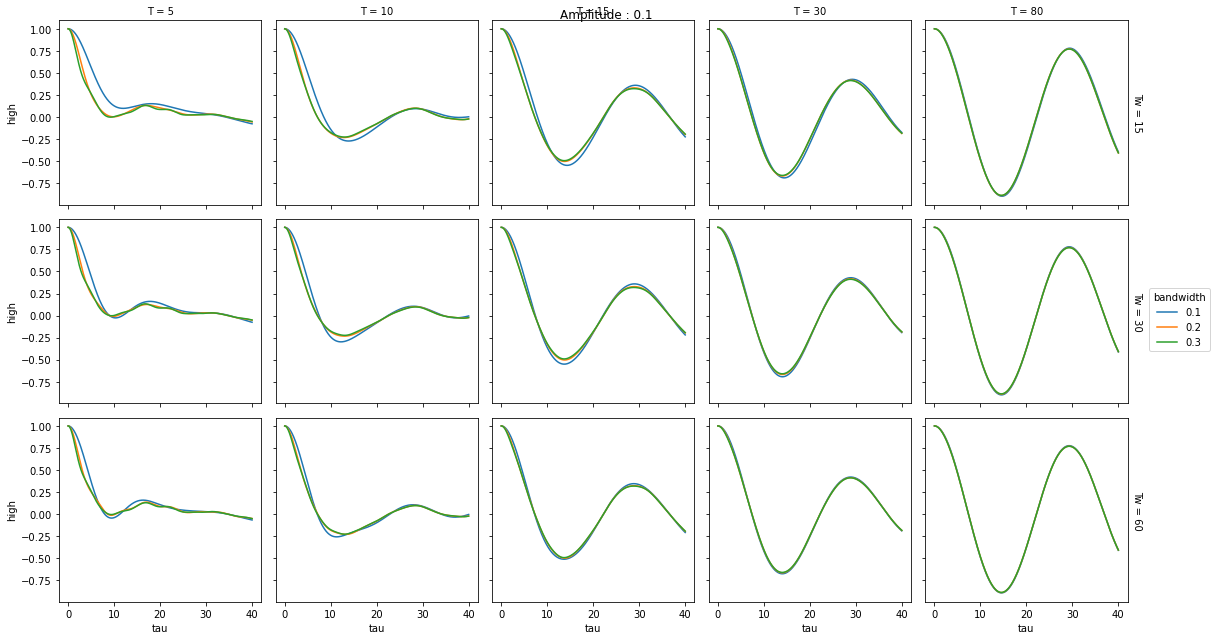

<Figure size 432x288 with 0 Axes>

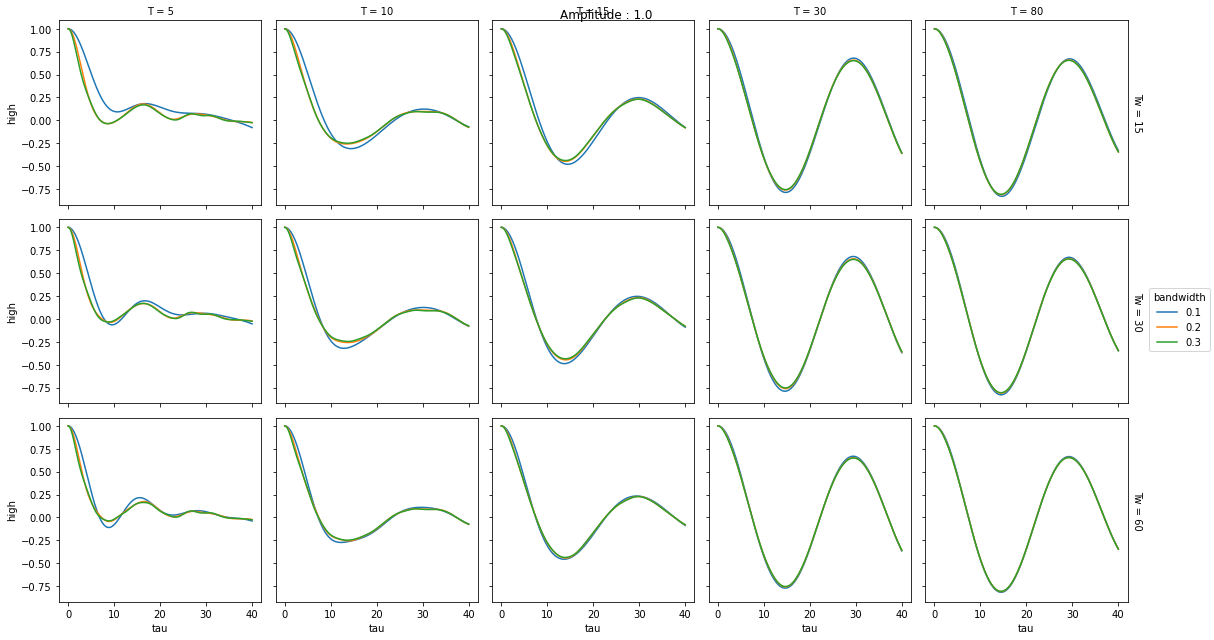

In [60]:
for U in ds_R.U_high:
    fig = plt.figure()
    (ds_R.high/ds_R.high.isel(tau=0)).sel(U_high=U).sel(tau=slice(0,40)).plot(hue='bandwidth',col='T',row='Tw')
    plt.suptitle('Amplitude : '+str(U.values));fig.tight_layout()
    

Notes : 

Larger kernel size decreases the dependence to the bandwidth at fixed decorrelation timescale.

For decorrelation timescale of 5 days, the spring neap cycle is not captured anymore (osclliations at shorter period appears).

Form for decorrelation timescales changes depending on the amplitude (stronger for T=5days).

NB : Here one possible explaination for oscillations of period shorter than spring neap cycle is decorrelation timescale too small compared to the cycle, no significant impact of bandwidth, etc in the observed cases (we did not test very small kernel size that could introduce new problems).

Comparison to monochromatic signal : 

The oscillations observed for $\tilde T\leq T_\omega$ observed in the monochromatic case are not observed anymore. The fact that the decorrelation timescale is shorter than the spring neap cycle seems to have a dominiant effect and creates oscillations even in cases of large enough bandwidth ($\tilde T \geq T_\omega$)

In [61]:
nb_draws = 50
u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()
da_high_M2 = tseries("high_M2", u_high,u_low,T,T_low,draws=nb_draws).rename('high_M2')
da_high_S2 = tseries("high_S2", u_high,u_low,T,T_low,draws=nb_draws).rename('high_S2')
da_low = tseries("low", u_high,u_low,T,T_low,draws=nb_draws)

#da_high_M2 = da_high_M2.rename('high_M2')
#da_high_S2 = xr.concat([tseries("high_S2") for i in range(nb)],dim='sample'
#                      ).assign_coords({'sample':np.arange(0,nb)})
#da_high_S2 = da_high_S2.rename('high_S2')
#da_low = xr.concat([tseries("low") for i in range(nb)],dim='sample').assign_coords({'sample':np.arange(0,nb)})

In [62]:
da_high_M2.attrs = {'sigma_M2':da_high_M2.attrs['sigma']}
da_high_S2.attrs = {'sigma_S2':da_high_S2.attrs['sigma']}

ds_stat = xr.merge([da_high_M2,da_high_S2, da_low.rename({'T':'T_low'})]) #, combine_attrs="no_conflicts"
#ds = ds.assign_coords({'T':T})
ds_stat

<xarray.Dataset>
Dimensions:  (T: 5, U_high: 4, time: 24000, draw: 50, T_low: 3)
Coordinates:
  * T        (T) int64 5 10 15 30 80
  * U_high   (U_high) float64 0.01 0.05 0.1 1.0
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * T_low    (T_low) int64 5 15 30
Data variables:
    high_M2  (T, U_high, time, draw) float64 dask.array<chunksize=(5, 4, 24000, 25), meta=np.ndarray>
    high_S2  (T, U_high, time, draw) float64 dask.array<chunksize=(5, 4, 24000, 25), meta=np.ndarray>
    low      (T_low, time, draw) float64 dask.array<chunksize=(3, 24000, 50), meta=np.ndarray>
Attributes:
    sigma_M2:  12.140833182614747

In [63]:
ds_stat['high'] = ds_stat.high_M2+ds_stat.high_S2
ds_stat['total'] = ds_stat.high_M2+ds_stat.high_S2+ds_stat.low

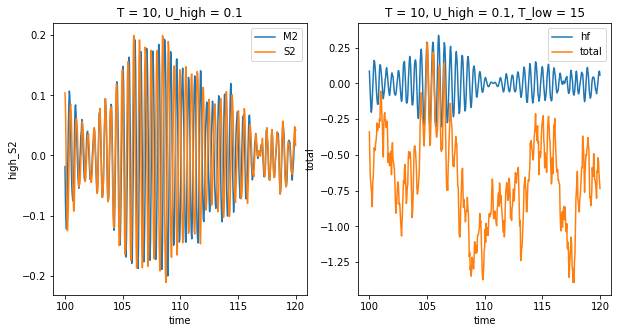

In [65]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ds_stat.high_M2.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).mean('draw').plot(ax=ax[0],label='M2')
ds_stat.high_S2.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).mean('draw').plot(ax=ax[0],label='S2')
ax[0].legend()
ds_stat.high.isel(T=1).sel(U_high=0.1).sel(time=slice(100,120)).mean('draw').plot(ax=ax[1],label='hf')
ds_stat.total.isel(T_low=1,T=1).sel(U_high=0.1).sel(time=slice(100,120)).mean('draw').plot(ax=ax[1],label='total')
ax[1].legend()

In [71]:
ds_stat.high.isel(draw=4,T=1,U_high=2).sel(time=slice(100,120)).values

distributed.worker - WARNING - Compute Failed
Function:  execute_task
args:      ((<function getitem at 0x2aab8b51b160>, (subgraph_callable-82b70109-0567-4f30-ba65-c9b97629b5b5, array([[[[ 1.61035210e-03],
         [ 1.27453591e-03],
         [ 1.14798652e-03],
         ...,
         [-1.08787708e-02],
         [-1.45641704e-02],
         [-1.48822179e-02]],

        [[-1.54700431e-03],
         [-1.68722855e-03],
         [-1.42560638e-02],
         ...,
         [-2.29842431e-02],
         [-3.76744535e-02],
         [-4.04959876e-02]],

        [[-6.21466806e-03],
         [-3.10460962e-02],
         [-1.67856958e-02],
         ...,
         [ 4.24274578e-02],
         [ 2.07466560e-02],
         [-6.92525415e-03]],

        [[ 1.50451993e-02],
         [-1.55434635e-01],
         [-8.84625795e-02],
         ...,
         [-7.07270389e-01],
         [-5.46692847e-01],
         [-3.45193137e-01]]],


       [[[ 1.04797166e-03],
         [-5.01090454e-04],
         [-5.40242324e-04],


IndexError: index 4 is out of bounds for axis 3 with size 1

In [70]:
ds_stat.high.isel(draw=1,T=1,U_high=2).sel(time=slice(100,120)).plot()
#ds_stat.high.isel(draw=4,T=1,U_high=2).sel(time=slice(100,120)).plot()

distributed.worker - WARNING - Compute Failed
Function:  execute_task
args:      ((<function getitem at 0x2aab8b51b160>, (subgraph_callable-82b70109-0567-4f30-ba65-c9b97629b5b5, array([[[[ 1.61035210e-03],
         [ 1.27453591e-03],
         [ 1.14798652e-03],
         ...,
         [-1.08787708e-02],
         [-1.45641704e-02],
         [-1.48822179e-02]],

        [[-1.54700431e-03],
         [-1.68722855e-03],
         [-1.42560638e-02],
         ...,
         [-2.29842431e-02],
         [-3.76744535e-02],
         [-4.04959876e-02]],

        [[-6.21466806e-03],
         [-3.10460962e-02],
         [-1.67856958e-02],
         ...,
         [ 4.24274578e-02],
         [ 2.07466560e-02],
         [-6.92525415e-03]],

        [[ 1.50451993e-02],
         [-1.55434635e-01],
         [-8.84625795e-02],
         ...,
         [-7.07270389e-01],
         [-5.46692847e-01],
         [-3.45193137e-01]]],


       [[[ 1.04797166e-03],
         [-5.01090454e-04],
         [-5.40242324e-04],


IndexError: index 1 is out of bounds for axis 3 with size 1

In [25]:
Tw = [15,30,60]
dband = [0.1,0.2,0.3]
_ds_stat = {}
for om,kind in zip([omega_M2,omega_S2,omega,omega],['high_M2','high_S2','high','total']):
    _ds_stat[kind] = xr.combine_nested([[sigp.bpass_demodulate(ds_stat[[kind]], om, band, tw)[0] for tw in Tw] for band in dband],concat_dim=['bandwidth','Tw']
                                 ).assign_coords({'Tw':Tw,'bandwidth':dband})#.compute()

In [ ]:
R_stat = {}
for kind in ['high_M2','high_S2','high','total']:
    R_stat[kind] = autocorrelations(_ds_stat[kind],[kind])

In [28]:
ds_R_stat = xr.merge([R_stat[kind] for kind in ['high_M2','high_S2','high','total']])

In [29]:
ds_R_mean = ds_R_stat.mean('sample')

In [31]:
ds_R_mean = ds_R_mean.persist()

In [ ]:
ds_R_mean.sel(T=29,Tw=30,U_high=0.1,bandwidth=0.2).high_M2.sel(tau=slice(0,40)).plot()

KeyboardInterrupt: 

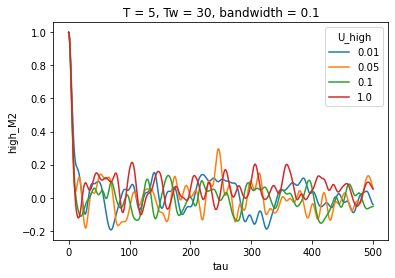

<Figure size 432x288 with 0 Axes>

In [30]:
(ds_R_mean.high_M2/ds_R_mean.high_M2.isel(tau=0)).sel(bandwidth=0.1,T=5,Tw=30).plot(hue='U_high')
plt.figure()
(ds_R_mean.high_M2/ds_R_mean.high_M2.isel(tau=0)).sel(bandwidth=0.1,Tw=30).plot(hue='U_high',col='T')

plt.figure()
(ds_R_mean.high_M2/ds_R_mean.high_M2.isel(tau=0)).sel(bandwidth=0.3,T=29).plot(hue='U_high',col='Tw')

plt.figure()
(ds_R_mean.high_M2/ds_R_mean.high_M2.isel(tau=0)).sel(T=29,U_high=0.1).plot(hue='bandwidth',col='Tw')

In [66]:
ds_R_mean_40 = ds_R_mean.sel(tau=slice(0,40)).compute()

KeyboardInterrupt: 

In [65]:
ds_R_mean.sel(T_low=20,T=29,Tw=30,U_high=0.1,bandwidth=0.2).high_M2.sel(tau=slice(0,40)).plot()

KeyboardInterrupt: 

ValueError: Line plots are for 1- or 2-dimensional DataArrays. Passed DataArray has 3 dimensions

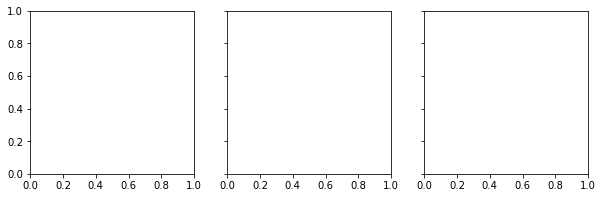

In [31]:
(ds_R['high']/ds_R['high'].isel(tau=0)).sel(U_high=0.1).sel(tau=slice(0,100)).plot(hue='T',col='Tw')

(ds_R['total']/ds_R['total'].isel(tau=0)).sel(U_high=0.1,T_low=5).sel(tau=slice(0,100)).plot(hue='T',col='Tw')

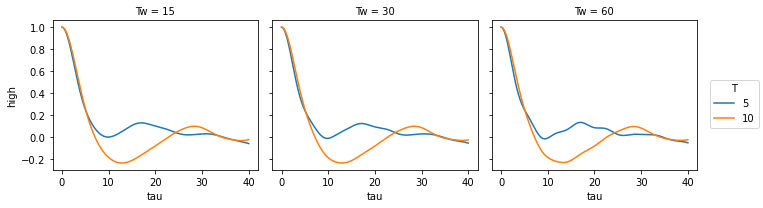

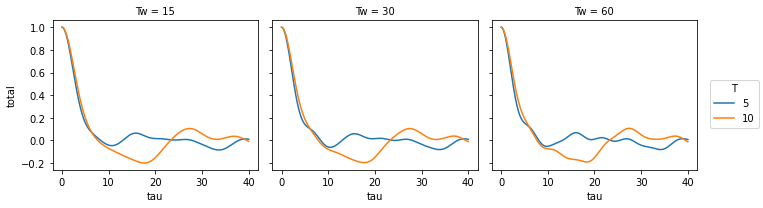

In [17]:
(ds_R['high']/ds_R['high'].isel(tau=0)).sel(U_high=0.1).sel(tau=slice(0,40)).sel(T=slice(5,10)).plot(hue='T',col='Tw')

(ds_R['total']/ds_R['total'].isel(tau=0)).sel(U_high=0.1,T_low=5).sel(tau=slice(0,40)).sel(T=slice(5,10)).plot(hue='T',col='Tw')

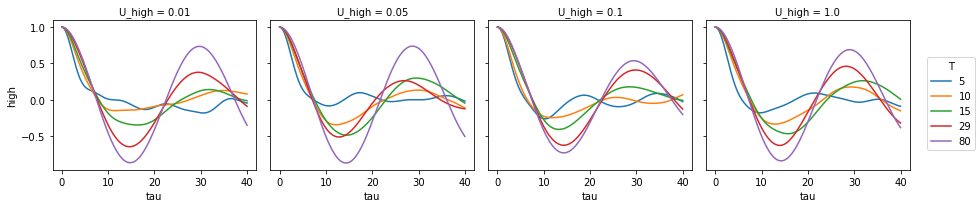

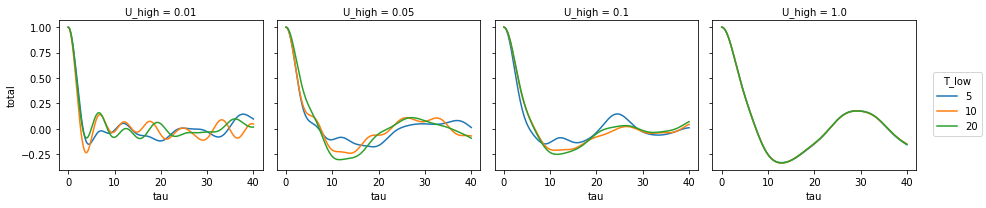

In [96]:
(ds_R['high']/ds_R['high'].isel(tau=0)).sel(Tw=30).sel(tau=slice(0,40)).plot(hue='T',col='U_high')
(ds_R['total']/ds_R['total'].isel(tau=0)).sel(T=10,Tw=30).sel(tau=slice(0,40)).plot(hue='T_low',col='U_high')

In [72]:
cluster.close()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/